In [27]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as sp
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression


In [2]:
def data_setup(level_array, level_type, ref_input, spec_input, heating_data = None):
    # open summed up reference data
    ref_data = xr.open_dataset(ref_input,
                         engine = "netcdf4")

    # Spectral flux data - fluxes per wavenumber
    spec_fluxes = xr.open_mfdataset(spec_input, 
                                    combine = 'nested', concat_dim = 'column',
                                   engine = "netcdf4")
    if (any(level_type == 'h')):
        # monochromatic heating
        heating = heating_data
        heating = heating.transpose("column", "half_level", "wavenumber")

        # heating = xr.open_dataset("/dx02/pc2943/mono_heating.h5", engine = "netcdf4")
        # heating = heating.rename({'mul-586aef02731ae840e3f7c86cffab3ac2':'mono_heating'})

    # set up coordinates/arrays
    wavenumber_coords = spec_fluxes.wavenumber.data

    num_cols = min(len(ref_data.column.data), len(spec_fluxes.column.data))
    
    ref = np.empty((len(level_array), num_cols))
    flux_subset = np.empty((len(level_array), num_cols, len(spec_fluxes.wavenumber.data)))

    for i in range(len(level_array)):
        if (level_type[i] == 'f'):
            if (level_array[i] == 0):
                # TOA outgoing fluxes
                TOA_up_spec = spec_fluxes.spectral_flux_up_lw.isel(half_level = 0).data
                TOA_up_ref = TOA_up_spec.sum(axis = 1)
                ref[i] = TOA_up_ref.compute()

                TOA_up_spec = TOA_up_spec.compute() 
                TOA_up_spec = np.array(TOA_up_spec)
                flux_subset[i] = TOA_up_spec

            elif (level_array[i] == 54):
                # ground downward fluxes
                BOA_dn_spec = spec_fluxes.spectral_flux_dn_lw.isel(half_level = 54).data
                BOA_dn_ref = BOA_dn_spec.sum(axis = 1)
                ref[i] = BOA_dn_ref.compute()

                BOA_dn_spec = BOA_dn_spec.compute()
                BOA_dn_spec = np.array(BOA_dn_spec)
                flux_subset[i] = BOA_dn_spec

            else:
                # net flux in interior levels
                lev_spec = (spec_fluxes.spectral_flux_dn_lw.isel(half_level = level_array[i]).data - 
                            spec_fluxes.spectral_flux_up_lw.isel(half_level = level_array[i]).data)
                flux_subset[i] = lev_spec
                ref[i] = lev_spec.sum(axis = 1)

        elif (level_type[i] == 'h'):
            # interior heating rates
            lev_spec = heating.mono_heating.isel(half_level = level_array[i]).data
            flux_subset[i] = lev_spec
            ref[i] = lev_spec.sum(axis = 1)

        else:
            print("level identifier must be either f(lux) or h(eating rate)")

    # assemble data into xarrays
    ref = xr.DataArray(data = ref, dims = ["half_level", "column"], 
                      coords = dict(half_level=(["half_level"], level_array)))

    flux_subset = xr.DataArray(data = flux_subset, dims = ["half_level", "column", "wavenumber"],
                              coords = dict(half_level=(["half_level"], level_array), 
                                            wavenumber=(["wavenumber"], wavenumber_coords)))

    return flux_subset, ref


In [3]:
def demean_and_normalize(train, test):
    # expects spectral dataset
    mean = train.mean(dim = 'column')
    std = train.std(dim = 'column')
    new_train = (train - mean)/(std**2)
    new_test = (test - mean)/(std**2)
    return new_train, new_test

In [31]:
def abs_rms(estimate, reference):
    # absolute root mean squared error across all ensembles
    # Buehler 2010 eqn 3
    return np.sqrt(((estimate - reference.data)**2).mean(axis = 1))


In [4]:
# load dataset
ref_input = "/data/robertp/CKDMIP_LBL/evaluation1/lw_fluxes/ckdmip_evaluation1_lw_fluxes_present.h5"
spec_input = ["/data/pc2943/spectral_fluxes_1-10.h5", "/data/pc2943/spectral_fluxes_11-20.h5",
                                "/data/pc2943/spectral_fluxes_21-30.h5", "/data/pc2943/spectral_fluxes_31-40.h5",
                                "/data/pc2943/spectral_fluxes_41-50.h5"]
specTest_input = ["/data/pc2943/eval2_spectral_fluxes_1-10.h5", "/data/pc2943/eval2_spectral_fluxes_11-20.h5",
                                "/data/pc2943/eval2_spectral_fluxes_21-30.h5", "/data/pc2943/eval2_spectral_fluxes_31-40.h5",
                                "/data/pc2943/eval2_spectral_fluxes_41-50.h5"]
refTest_input = "/data/robertp/CKDMIP_LBL/evaluation2/lw_fluxes/ckdmip_evaluation2_lw_fluxes-4angle_present.h5"

level_array = np.array([0])
level_type = np.array(['f'])
spec_train, ref_train = data_setup(level_array, level_type, ref_input, spec_input, None)
spec_test, ref_test = data_setup(level_array, level_type, refTest_input, specTest_input, None)


In [5]:
# demean and normalize data for PCA
spec_train, spec_test = demean_and_normalize(spec_train, spec_test)

In [24]:
# SVD
# P, sigma, S = np.linalg.svd(spec_train[0].T)

MemoryError: Unable to allocate 378. TiB for an array with shape (7211999, 7211999) and data type float64

Matrix is too large to compute SVD. First solution option: uniformly sample the dataset to reduce the space to about 100,000 predictors (seems like the largest set the computer will handle). 

In [28]:
reduced_spec_train = spec_train[0, :, ::80]
reduced_spec_test = spec_test[0, :, ::80]

In [7]:
np.shape(reduced_spec_train.T)

(90150, 50)

In [8]:
# SVD
P, sigma, S = np.linalg.svd(reduced_spec_train.data.T)

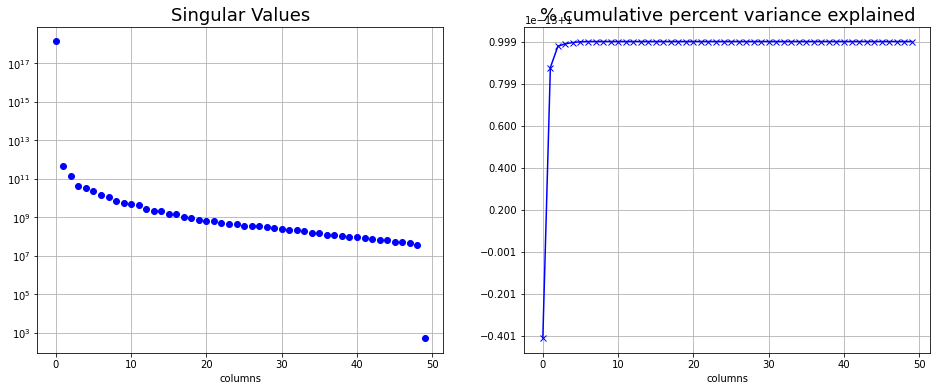

In [9]:
fig = plt.figure(figsize=(16,6))
axes = fig.add_subplot(1, 2, 1)
axes.semilogy(sigma,'bo')
axes.grid()
axes.set_xlabel('columns')

axes.set_title('Singular Values', fontsize=18)

#and cumulative percent of variance
axes = fig.add_subplot(1, 2, 2)
g = np.cumsum(sigma*sigma)/np.sum(sigma*sigma)
axes.plot(g,'bx-')

axes.set_title('% cumulative percent variance explained', fontsize=18)
axes.set_xlabel('columns')
axes.grid()

plt.show()

In [33]:
### Principal Component Regression
pca = PCA()
predictor_var = pca.fit_transform(reduced_spec_train.data)
test_var = pca.fit_transform(reduced_spec_test.data)

In [91]:
val_array = np.arange(1, 50)
test_MSE = np.empty(len(val_array))
train_MSE = np.empty(len(val_array))
for i in range(len(val_array)):
    X = predictor_var[:, :val_array[i]]
    X_test = test_var[:, :val_array[i]]
    regression = LinearRegression()
    regression.fit(X, ref_train.data[0])
    y_train = regression.predict(X)
    y_test = regression.predict(X_test)
    train_MSE[i] = abs_rms(y_train, ref_train.data)
    test_MSE[i] = abs_rms(y_test, ref_test)

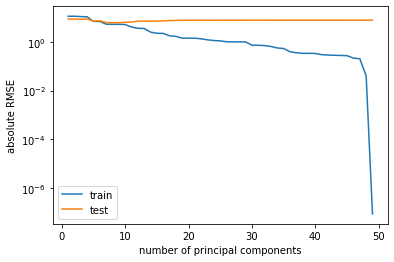

In [93]:
plt.semilogy(val_array, train_MSE)
plt.semilogy(val_array, test_MSE)
plt.ylabel("absolute RMSE")
plt.xlabel("number of principal components")
plt.legend(["train", "test"])
plt.show()